<a href="https://colab.research.google.com/github/Indu2204/StanfordAudiology-1/blob/main/Codes/Cluster_vs_ClassificationType.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Packages

In [1]:
import numpy as np
import dataclasses
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import warnings

## Authenticating google spreadsheet


In [2]:
from google.colab import auth
import gspread
from google.auth import default  #autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

## Importing the dataset from google spreadsheet

In [3]:
"""
Change is required in the url. Open the spreadsheet mfb raw audio and copy 
the link from the address bar. The gid code in the url is unique.
"""
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/119_-qrfzGXwV1YBUJdBzvtAQTZnl-xwN7hD9FK5SWfU/edit#gid=84023254').sheet1 #get_all_values gives a list of rows
rows = worksheet.get_all_values()

In [4]:
# Rename duplicate column name. (Data appears identical, so probably a mistake)
lbone2000_indices = [i for i in range(len(rows[0])) if rows[0][i] == 'LBone2000']
rows[0][lbone2000_indices[1]] = 'LBone2000Dupe'

In [5]:
# Convert spaces in all column names to _ so they can be field names.
column_names = [s.replace(' ', '_') for s in rows[0]]

In [6]:
StanfordData = dataclasses.make_dataclass('stanford_data', column_names)

In [7]:
all_stanford_data = [StanfordData(*rows[i]) for i in range(1, len(rows))]

In [8]:
from typing import List

def collect_array(sd: List[dataclasses.dataclass], 
                  field_list: List[str],
                  type=np.float32) -> np.ndarray:
  """Collect the data from each field listed in list and return a single
  numpy array with all the data. 

  Args:
    sd: A list of Stanford dataclass objects (holding the audiogram data)
    field_list: A list of column names to extract
    type: The desired data type, should be a NP type or object.
  """
  data = np.zeros((len(sd), len(field_list)), dtype=type)
  for i, r in enumerate(sd):
    for j, f in enumerate(field_list):
      d = r.__getattribute__(f)

      if type==np.float32 or type==np.float64:
        if d == '' or d == 'NR':
          d = np.nan
        else:
          try:
            d = float(d)
          except:   # Last resort
            d = np.nan

      data[i, j] = d
  return data

In [9]:
# Figure out which rows have missing (NaN) data in them.
def remove_nans(data):
  num_nans_row = np.sum(np.isnan(data), axis=1)
  good_rows = [i for i in range(len(num_nans_row)) if num_nans_row[i] == 0]
  bad_rows = [i for i in range(len(num_nans_row)) if num_nans_row[i] > 0]
  good_data = data[good_rows,:]
  return (good_data,good_rows)

In [10]:
"""
Identifying the index of rows that have valid age entry as noted 
on the test day
"""
#Collecting the entire column from the main dataframe
age_data = collect_array(all_stanford_data,['AgeAtTestDate']) 

good_age_rows,_ = np.where((age_data >=0) & (age_data <=100))
good_age_data = age_data[good_age_rows]
good_age_data.shape

(76807, 1)

In [11]:
columns = ['AgeAtTestDate','R250', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 
           'R6000', 'R8000','L250', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 
           'L6000', 'L8000', 'RBone500',	'RBone1000',	'RBone2000', 
           'RBone4000', 'LBone500',	'LBone1000',	'LBone2000', 'LBone4000',
           'MonSNR_Score_R', 'Word_Rec_Score_R','MonSNR_Score_L',
           'Word_Rec_Score_L']
data = collect_array(all_stanford_data,columns) 

#Collecting data corresponding to indices with valid age entires
data_final = data[good_age_rows,:]
data_final.shape

(76807, 29)

## HL Classification

In [12]:
"""
Reading the dataframes containing HL at audiometric frequencies and 
HL for bone conduction based test to classify the type of hearling loss
"""
df = pd.DataFrame(data_final, columns = columns)

In [13]:
"""
function that takes in audiometric frequencies and returns the hearling 
loss class
"""
audiometric_freq_1 = ['R250', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 
                    'R8000','L250', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 
                    'L6000', 'L8000', 'RBone500','RBone1000','RBone2000',
                    'RBone4000', 'LBone500', 'LBone1000', 'LBone2000',
                    'LBone4000']
"""
I am assuming we pass a set of dataframes corresponding to the audiometric 
frequencies 
"""
def HL_loss_classifier(df):
  """
  To calculate different metrics that will be used as criterion for classifying
  the hearing loss types

  Args:
    df:  dataframe with HL measurements at audiometric frequencies

  Returns:
    df: dataframe with HL classes as a new column
  """
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    #HFPTA
    df_hfpta_R  = df[['R1000', 'R2000', 'R4000']]
    df_hfpta_L  = df[['L1000', 'L2000', 'L4000']]
    HFPTA_R = np.array(np.nanmean(df_hfpta_R.to_numpy(),axis=1))
    HFPTA_L = np.array(np.nanmean(df_hfpta_L.to_numpy(),axis=1))
    df.loc[:,'R_HFPTA'] = HFPTA_R
    df.loc[:,'L_HFPTA'] = HFPTA_L

    # PTA - 500, 1000, 2000 
    df_pta_R = df[['R500', 'R1000', 'R2000']]
    df_pta_L = df[['L500', 'L1000', 'L2000']]
    PTA_R = np.array(np.nanmean(df_pta_R.to_numpy(),axis=1))
    PTA_L = np.array(np.nanmean(df_pta_L.to_numpy(),axis=1))
    df.loc[:,'R_PTA'] = PTA_R
    df.loc[:,'L_PTA'] = PTA_L

    #PTA all -  500,1000,2000,4000
    df_pta_all_R = df[['R500', 'R1000', 'R2000', 'R4000']]
    df_pta_all_L = df[['L500', 'L1000', 'L2000', 'L4000']]
    PTA_all_R = np.array(np.nanmean(df_pta_all_R.to_numpy(),axis=1))
    PTA_all_L = np.array(np.nanmean(df_pta_all_L.to_numpy(),axis=1))
    df.loc[:,'R_PTA_All'] = PTA_all_R
    df.loc[:,'L_PTA_All'] = PTA_all_L

    #LFPTA -  250, 500,1000
    df_lfpta_R = df[['R500', 'R1000']]
    df_lfpta_L = df[['L500', 'L1000']]
    LFPTA_R = np.array(np.nanmean(df_lfpta_R.to_numpy(),axis=1))
    LFPTA_L = np.array(np.nanmean(df_lfpta_L.to_numpy(),axis=1))
    df.loc[:,'R_LFPTA'] = LFPTA_R
    df.loc[:,'L_LFPTA'] = LFPTA_L

    #UHFPTA - 2000, 4000, 80000
    df_uhfpta_R = df[['R2000', 'R4000', 'R8000']]
    df_uhfpta_L = df[['L2000', 'L4000', 'L8000']]
    UHFPTA_R = np.array(np.nanmean(df_uhfpta_R.to_numpy(),axis=1))
    UHFPTA_L = np.array(np.nanmean(df_uhfpta_L.to_numpy(),axis=1))
    df.loc[:,'R_UHFPTA'] = UHFPTA_R
    df.loc[:,'L_UHFPTA'] = UHFPTA_L

    #PT Bone conduction modeled
    df_pta_BC_mod_R = df[['RBone500', 'RBone1000', 'RBone2000']]
    df_pta_BC_mod_L = df[['LBone500', 'LBone1000', 'LBone2000']]
    PTA_BC_mod_R = np.array(np.nanmean(df_pta_BC_mod_R.to_numpy(), axis=1))
    PTA_BC_mod_L = np.array(np.nanmean(df_pta_BC_mod_L.to_numpy(), axis=1))
    df.loc[:,'R_PTA_BC_Mod'] = PTA_BC_mod_R
    df.loc[:,'L_PTA_BC_Mod'] = PTA_BC_mod_L

    #HFPTA Bone conduction modeled
    df_hfpta_BC_mod_R = df[['RBone1000', 'RBone2000','RBone4000']]
    df_hfpta_BC_mod_L = df[['LBone1000', 'LBone2000','LBone4000']]
    HFPTA_BC_mod_R = np.array(np.nanmean(df_hfpta_BC_mod_R.to_numpy(),axis=1))
    HFPTA_BC_mod_L = np.array(np.nanmean(df_hfpta_BC_mod_L.to_numpy(),axis=1))
    df.loc[:,'R_HFPTA_BC_Mod'] = HFPTA_BC_mod_R
    df.loc[:,'L_HFPTA_BC_Mod'] = HFPTA_BC_mod_L

    #BC average of 500, 1, 2, 4
    df_hfpta_BC_avg_R = df[['RBone500','RBone1000', 'RBone2000','RBone4000']]
    df_hfpta_BC_avg_L = df[['LBone500','LBone1000', 'LBone2000','LBone4000']]
    HFPTA_BC_avg_R = np.array(np.nanmean(df_hfpta_BC_avg_R.to_numpy(),axis=1))
    HFPTA_BC_avg_L = np.array(np.nanmean(df_hfpta_BC_avg_L.to_numpy(),axis=1))
    df.loc[:,'R_PTA_BC_All'] = HFPTA_BC_avg_R
    df.loc[:,'L_PTA_BC_All'] = HFPTA_BC_avg_L

    # new ABGap
    df.loc[:,'R_PTA_ABGap'] = df['R_PTA'] - df['R_PTA_BC_Mod']
    df.loc[:,'R_HFPTA_ABGap'] = df['R_HFPTA'] - df['R_HFPTA_BC_Mod']
    df.loc[:,'R_PTA_All_ABGap'] = df['R_PTA_All'] - df['R_PTA_BC_All']

    df.loc[:,'L_PTA_ABGap'] = df['L_PTA'] - df['L_PTA_BC_Mod']
    df.loc[:,'L_HFPTA_ABGap'] = df['L_HFPTA'] - df['L_HFPTA_BC_Mod']
    df.loc[:,'L_PTA_All_ABGap'] = df['L_PTA_All'] - df['L_PTA_BC_All']

    #HL Type
    #Right
    # using the new Modeled BC PTA of 5, 1, 2
    conditions_1 = [(df['R_PTA_BC_Mod'] < 25.1) & (df['R_PTA_ABGap'] >= 10) & (df['R_PTA'] > 25), 
                    (df['R_PTA_ABGap'] < 10) & (df['R_PTA'] > 25), 
                    (df['R_PTA_BC_Mod'] > 25) & (df['R_PTA_ABGap'] >= 10) & (df['R_PTA'] > 25)]
    values = ['Conductive','SNHL','Mixed']
    df['R_Type_HL_Mod']= np.select(conditions_1, values)
    df.loc[df["R_Type_HL_Mod"] == '0' , "R_Type_HL_Mod"] = 'Normal'

    # HFPTA of 1 
    conditions_2 = [(df['R_HFPTA_BC_Mod'] < 25.1) & (df['R_HFPTA_ABGap'] >= 10) & (df['R_HFPTA'] > 25), 
                    (df['R_HFPTA_ABGap'] < 10) & (df['R_HFPTA'] > 25), 
                    (df['R_HFPTA_BC_Mod'] > 25) & (df['R_HFPTA_ABGap'] >= 10) & (df['R_HFPTA'] > 25)]
    values = ['Conductive','SNHL','Mixed']
    df['R_Type_HL_HF'] = np.select(conditions_2, values)
    df.loc[df["R_Type_HL_HF"] == '0' , "R_Type_HL_HF"] = 'Normal'

    # # PTA of 500 1 2 4
    conditions_3 = [(df['R_PTA_BC_All'] < 25.1) & (df['R_PTA_All_ABGap'] >= 10) & (df['R_PTA_All'] > 25), 
                    (df['R_PTA_All_ABGap'] < 10) & (df['R_PTA_All'] > 25), 
                    (df['R_PTA_BC_All'] > 25) & (df['R_PTA_All_ABGap'] >= 10) & (df['R_PTA_All'] > 25)
                    ]
    values = ['Conductive','SNHL','Mixed']
    df['R_Type_HL_All'] = np.select(conditions_3, values)
    df.loc[df["R_Type_HL_All"] == '0' , "R_Type_HL_All"] = 'Normal'
  return df

In [95]:
def HL_plot(df, title = None):
  """
  df - dataframe that contains hearing Threshold class as a column
  title - title of the plot (incase when needed)

  Plots the Avg air conduction vs Avg bone conduction threshold

  """
  df_normal = df.loc[df['R_Type_HL_All'] == 'Normal']
  df_snhl = df.loc[df['R_Type_HL_All'] == 'SNHL']
  df_conductive = df.loc[df['R_Type_HL_All'] == 'Conductive']
  df_mixed = df.loc[df['R_Type_HL_All'] == 'Mixed']

  plt.scatter(df_normal['R_PTA_BC_All'], df_normal['R_PTA_All'], color = 'r',alpha = 0.5, label = 'Normal')
  plt.scatter(df_snhl['R_PTA_BC_All'], df_snhl['R_PTA_All'], color = 'b',alpha = 0.5, label = 'SNHL')
  plt.scatter(df_conductive['R_PTA_BC_All'], df_conductive['R_PTA_All'], alpha = 0.5, color = 'g', label = 'Conductive')
  plt.scatter(df_mixed['R_PTA_BC_All'], df_mixed['R_PTA_All'], color = 'black',alpha = 0.5, label = 'Mixed')

  plt.xlabel('Average Bone Conduction Threshold')
  plt.ylabel("Average Air Conduction Threshold")
  plt.title(title)
  plt.legend()
  plt.show()

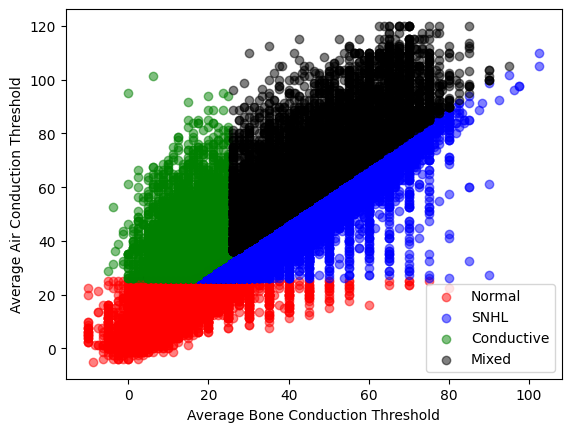

In [15]:
#With acutal data
data_actual = df.loc[:,audiometric_freq_1]
df_actual = HL_loss_classifier(data_actual)
HL_plot(df_actual)

## Clustering based on audiometric frequencies of right ear

In [25]:
hl_right_labels = [ 'R250',	'R500',	'R1000',	'R2000',	'R3000',	'R4000',	'R6000',	'R8000']
hl_right = df_actual.dropna(subset = hl_right_labels)
hl_right = hl_right[hl_right_labels]

In [26]:
hl_right

,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000
0,55.0,60.0,60.0,60.0,50.0,45.0,50.0,55.0
1,45.0,40.0,35.0,50.0,40.0,50.0,50.0,45.0
2,20.0,15.0,15.0,15.0,20.0,25.0,30.0,25.0
3,15.0,15.0,20.0,10.0,0.0,0.0,0.0,10.0
4,15.0,15.0,10.0,5.0,10.0,15.0,15.0,30.0
...,...,...,...,...,...,...,...,...
76797,75.0,85.0,85.0,75.0,75.0,70.0,70.0,75.0
76798,40.0,40.0,50.0,60.0,75.0,85.0,80.0,80.0
76799,30.0,25.0,20.0,15.0,10.0,10.0,10.0,15.0
76802,20.0,25.0,30.0,40.0,45.0,55.0,60.0,70.0


In [27]:
from sklearn.cluster import KMeans

In [28]:
#6 clusters
n = 6
kmeans_6 = KMeans(n_clusters=n, init='k-means++', max_iter=1000, n_init=10, random_state=0)
kmeans_6.fit(hl_right) #To compute cluster centres 

KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=0)

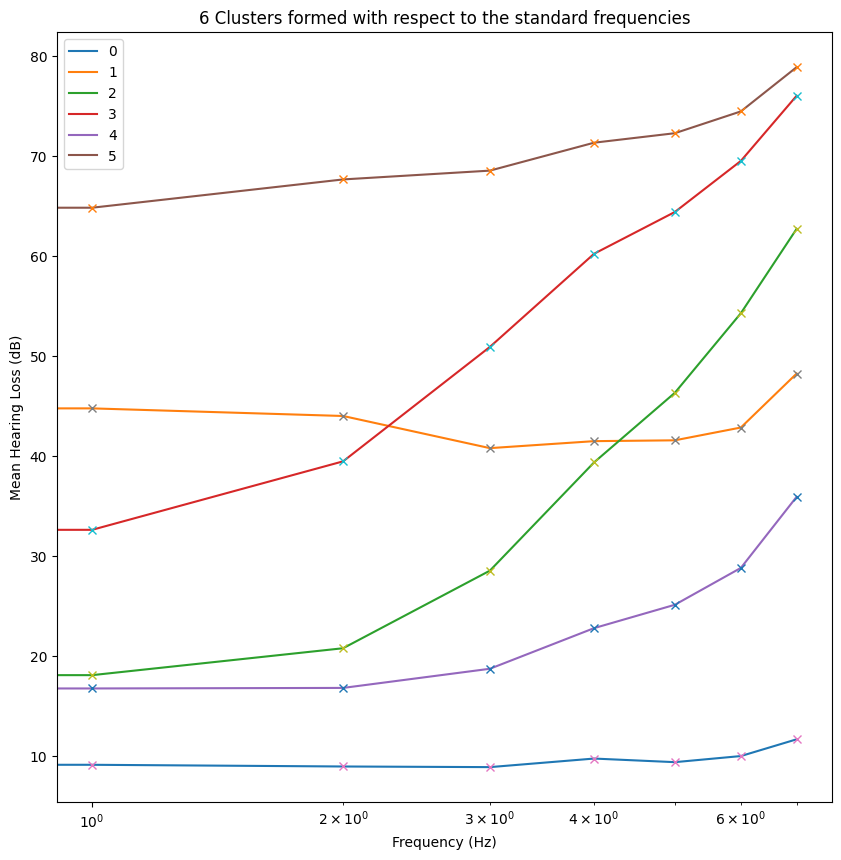

In [29]:
"""
Fixing colours for cluster centroids (fix for maximum number of cluster that 
will be potentially formed. 
It will be easy to draw inferences from diffect clusters formed)
"""
color = plt.cm.rainbow(np.linspace(0, 1, 6))

#Plot
plt.figure(figsize=(10,10))
for i, c in zip(range(n), color):
  plt.plot(hl_right_labels, kmeans_6.cluster_centers_.T[:,i], label = i)
  plt.legend()
plt.semilogx(hl_right_labels, kmeans_6.cluster_centers_.T, 'x')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mean Hearing Loss (dB)')
plt.title('6 Clusters formed with respect to the standard frequencies')
plt.show()

In [30]:
#Count of number of patients in each of the cluster
predictions_6 = np.ndarray.tolist(kmeans_6.predict(hl_right))
labels = np.unique(kmeans_6.labels_)
count = {}
for i in labels:
  count_temp = predictions_6.count(i)
  count[i] = count_temp
print("For 6 clusters count:", count)

For 6 clusters count: {0: 15687, 1: 5379, 2: 10047, 3: 8972, 4: 12670, 5: 4960}


In [31]:
"""
Obtaining the index of rows of audiogram freq samples as the values of index 
corresponding to the original index of mfb audio xlsx sheet
"""

good_index = df.index.values
#Fiding the index positions of each of the cluster

index_label0 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 0 ]
index_label1 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 1 ]
index_label2 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 2 ]
index_label3 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 3 ]
index_label4 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 4 ]
index_label5 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 5 ]

In [32]:
df_actual.loc[index_label0,'Cluster_labels'] = 'Mid Slope'
df_actual.loc[index_label1,'Cluster_labels'] = 'Mid Flat'
df_actual.loc[index_label2,'Cluster_labels'] = 'Low Flat'
df_actual.loc[index_label3,'Cluster_labels'] = 'High Slope'
df_actual.loc[index_label4,'Cluster_labels'] = 'High Flat'
df_actual.loc[index_label5,'Cluster_labels'] = 'Low Slope'

In [33]:
df_actual

,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000,L250,L500,...,R_PTA_ABGap,R_HFPTA_ABGap,R_PTA_All_ABGap,L_PTA_ABGap,L_HFPTA_ABGap,L_PTA_All_ABGap,R_Type_HL_Mod,R_Type_HL_HF,R_Type_HL_All,Cluster_labels
0,55.0,60.0,60.0,60.0,50.0,45.0,50.0,55.0,30.0,30.0,...,46.666668,36.666664,41.25,8.333332,5.000000,7.50,Conductive,Conductive,Conductive,Mid Flat
1,45.0,40.0,35.0,50.0,40.0,50.0,50.0,45.0,40.0,40.0,...,25.000002,28.333334,26.25,15.000002,10.000000,12.50,Conductive,Conductive,Conductive,Mid Flat
2,20.0,15.0,15.0,15.0,20.0,25.0,30.0,25.0,30.0,40.0,...,10.000000,8.333334,10.00,21.666664,16.666668,20.00,Normal,Normal,Normal,High Flat
3,15.0,15.0,20.0,10.0,0.0,0.0,0.0,10.0,5.0,10.0,...,10.000000,6.666667,7.50,3.333333,3.333333,3.75,Normal,Normal,Normal,Mid Slope
4,15.0,15.0,10.0,5.0,10.0,15.0,15.0,30.0,10.0,15.0,...,1.666667,3.333333,3.75,NaN,6.666667,8.75,Normal,Normal,Normal,Mid Slope
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76802,20.0,25.0,30.0,40.0,45.0,55.0,60.0,70.0,20.0,30.0,...,NaN,-8.333332,-12.50,5.000000,6.666668,5.00,Normal,SNHL,SNHL,NaN
76803,50.0,60.0,60.0,60.0,NaN,75.0,NaN,65.0,50.0,60.0,...,13.333332,15.000000,15.00,18.333332,18.333332,18.75,Mixed,Mixed,Mixed,NaN
76804,50.0,50.0,50.0,45.0,NaN,70.0,NaN,65.0,30.0,30.0,...,10.000000,8.333332,10.00,0.000000,3.333332,2.50,Mixed,SNHL,Mixed,NaN
76805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,25.0,...,NaN,NaN,NaN,3.333334,0.000000,1.25,Normal,Normal,Normal,NaN


In [34]:
df_cluster_class = df_actual[['R_Type_HL_All','Cluster_labels']]
df_cluster_class = df_cluster_class.dropna()
df_cluster_class

,R_Type_HL_All,Cluster_labels
0,Conductive,Mid Flat
1,Conductive,Mid Flat
2,Normal,High Flat
3,Normal,Mid Slope
4,Normal,Mid Slope
...,...,...
57710,Normal,Low Slope
57711,Normal,High Slope
57712,Normal,Mid Slope
57713,Normal,Low Flat


In [35]:
df_cluster_class_normal = df_cluster_class.loc[df_cluster_class['R_Type_HL_All'] == 'Normal']
df_cluster_class_snhl = df_cluster_class.loc[df_cluster_class['R_Type_HL_All'] == 'SNHL']
df_cluster_class_conductive = df_cluster_class.loc[df_cluster_class['R_Type_HL_All'] == 'Conductive']
df_cluster_class_mixed = df_cluster_class.loc[df_cluster_class['R_Type_HL_All'] == 'Mixed']

In [92]:
df_group = df_actual.groupby("Cluster_labels", group_keys=True)

In [88]:
cluster_types = ['Low Slope', 'High Flat', 'High Slope', 'Low Flat', 'Mid Flat', 'Mid Slope']

Cluster type : Low Slope
R_Type_HL_All
Conductive     305
Mixed         1748
Normal        1247
SNHL          1660
Name: Cluster_labels, dtype: int64


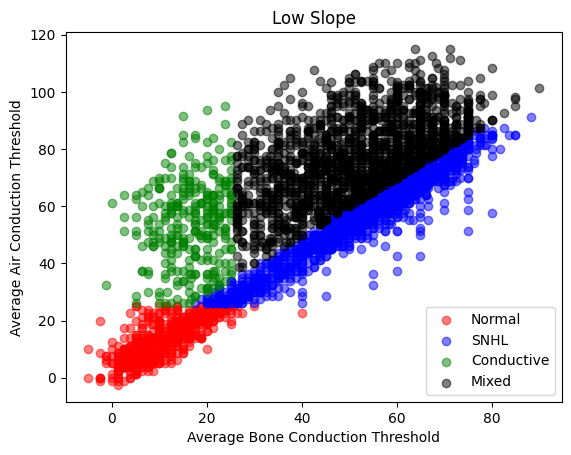



Cluster type : High Flat
R_Type_HL_All
Conductive     891
Mixed          487
Normal        7191
SNHL          4101
Name: Cluster_labels, dtype: int64


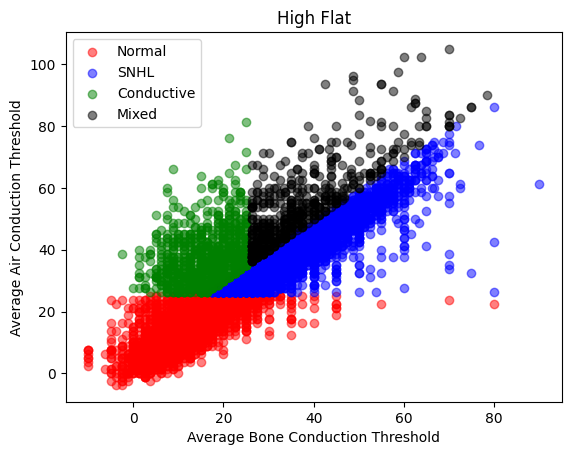



Cluster type : High Slope
R_Type_HL_All
Conductive     778
Mixed         1600
Normal        2543
SNHL          4051
Name: Cluster_labels, dtype: int64


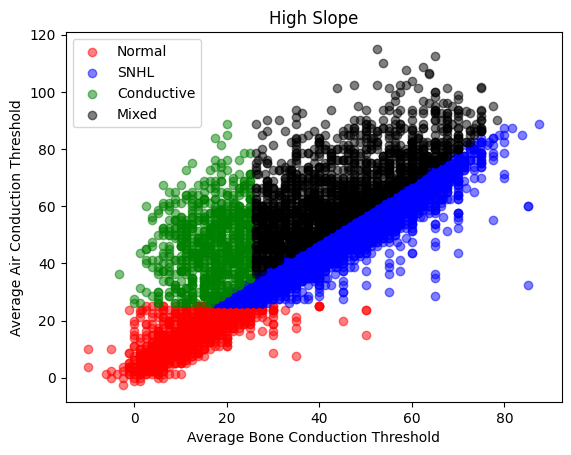



Cluster type : Low Flat
R_Type_HL_All
Conductive     744
Mixed          539
Normal        5116
SNHL          3648
Name: Cluster_labels, dtype: int64


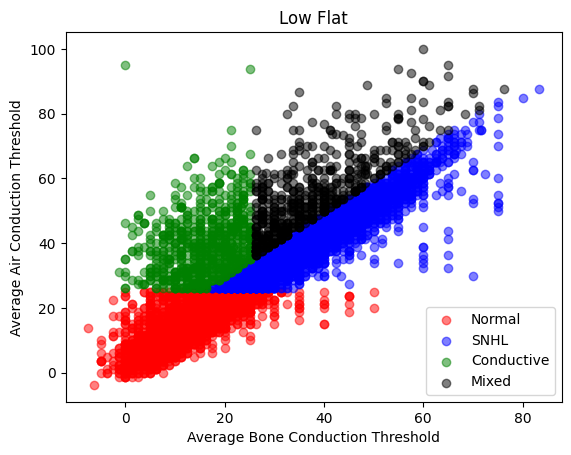



Cluster type : Mid Flat
R_Type_HL_All
Conductive     501
Mixed          886
Normal        1730
SNHL          2262
Name: Cluster_labels, dtype: int64


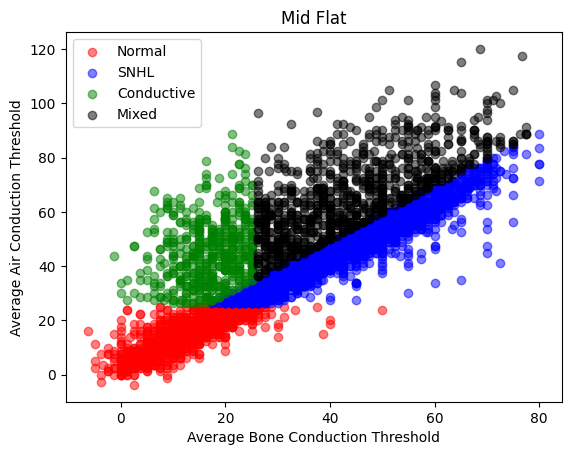



Cluster type : Mid Slope
R_Type_HL_All
Conductive    1085
Mixed          416
Normal        9445
SNHL          4741
Name: Cluster_labels, dtype: int64


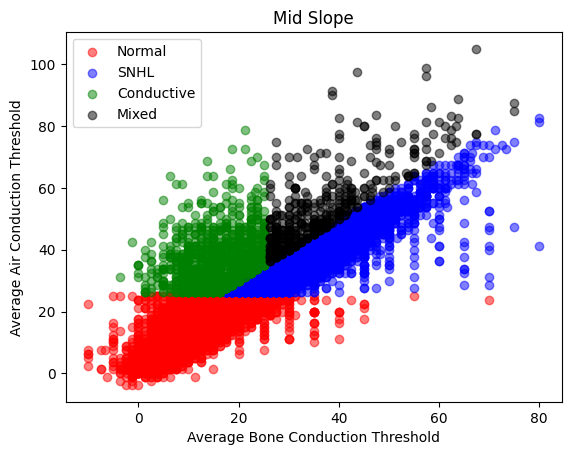

In [104]:
for cluster_type in cluster_types:
  temp = df_group.get_group(cluster_type)
  print("Cluster type : {}".format(cluster_type))
  count = temp.groupby('R_Type_HL_All', group_keys = True).count()
  print(count['Cluster_labels'])
  HL_plot(temp, title = cluster_type)
  print('\n')